In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


# 데이터 불러오기

In [2]:
cifar10 = tf.keras.datasets.cifar10 # cifar10 데이터를 불러온다

(train_x, _), (test_x, _) = cifar10.load_data() # train_x,test_x 데이터만 로드한다

train_x.shape # x_train의 shape 출력

(50000, 32, 32, 3)

# 데이터 전처리

In [3]:
print("max pixel:", train_x.max()) # train_x의 가장 큰 픽셀 값 출력
print("min pixel:", train_x.min()) # train_x의 가장 작은 픽셀 값 출력

max pixel: 255
min pixel: 0


In [4]:
# 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠줍니다.
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max()) # 정규화 한 train_x의 가장 큰 픽셀 값 출력
print("min pixel:", train_x.min()) # 정규화 한 train_x의 가장 작은 픽셀 값 출력

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape # train_x의 shape 확인

(50000, 32, 32, 3)

In [6]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32') # 데이터를 float형으로 타입변경을 해준다
# train_x.shape[0]을 앞에 넣은 이유는 train_x의 shape = (50000,32,32,3) 그 중 젤 처음 값인 50000을 불러오는 것 같다.
train_x.shape # reshape한 train_x의 shape 확인

(50000, 32, 32, 3)

# 데이터 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


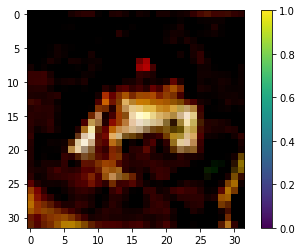

In [7]:
plt.imshow(train_x[0].reshape(32, 32, 3)) # train_x의 0번째 이미지를 불러온다
plt.colorbar() # 옆에 컬러바를 표시한다
plt.show() # 불러온 이미지를 시각화 한다

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

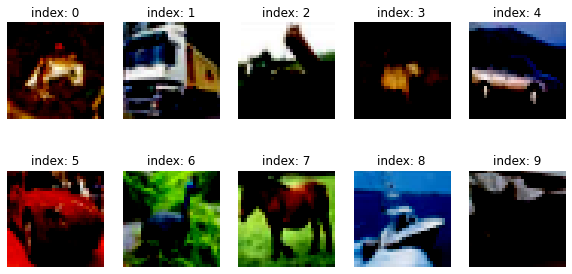

In [8]:
plt.figure(figsize=(10, 5)) # figure의 사이즈를 정한다

for i in range(10):
    plt.subplot(2, 5, i+1) # 2행 5열로 만들고 1-10까지 순서대로 figure에 이미지를 넣는다
    plt.imshow(train_x[i].reshape(32, 32,3)) # i번째 이미지를 불러온다
    plt.title(f'index: {i}') # 몇번째 인덱스라는 타이틀을 달아준다
    plt.axis('off') # 그래프의 테두리 선을 없애준다
plt.show() # 불러온 이미지를 보여준다

In [9]:
BUFFER_SIZE = 50000 # BUFFER_SIZE은 전체 데이터를 섞기 위해 50,000으로 설정
BATCH_SIZE = 256 #  모델이 한 번에 학습할 데이터의 양

In [10]:
# tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있음
# train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다.
# 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
def make_generator_model():# make_generator_model이라는 함수를 만들어서 언제든 생성자를 생성

    # Start
    model = tf.keras.Sequential() # Sequential 정의

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,))) 
    #use_bias : 부울, 레이어에서 바이어스 벡터를 사용하는지 여부.
    model.add(layers.BatchNormalization()) # 입력을 정규화
    model.add(layers.LeakyReLU(0.2)) # 활성화 함수

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    # Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층
    # 이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (8, 8, 256) → (16, 16, 64) → (32, 32, 1) 순으로 이미지를 키운다
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    # padding : 경계 처리 방법을 정의합니다.
    # - padding = ‘valid’ : 유효한 영역만 출력이 됩니다. 따라서 출력 이미지 사이즈는 입력 사이즈보다 작습니다.
    # - padding = ‘same’ : 출력 이미지 사이즈가 입력 이미지 사이즈와 동일합니다.
    #  BatchNormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시킴
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2)) # 활성화 함수

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Fifth: Conv2DTranspose layer
    # 마지막 층에는 활성화 함수로 tanh를 사용하는데, 이는 우리가 -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False,activation='tanh'))

    return model

In [12]:
generator = make_generator_model() # make_generator_model모델을 generator에 불러온다

generator.summary() # 모델 확인

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [13]:
noise = tf.random.normal([1, 100]) # 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있음

In [14]:
generated_image = generator(noise, training=False) # noise를 입력으로 받음, 지금은 학습하는 중이 아니니 training=False를 설정
generated_image.shape

TensorShape([1, 32, 32, 3])

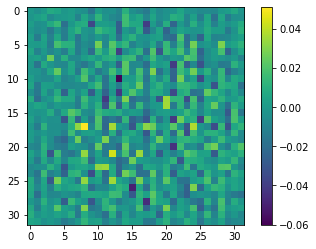

In [15]:
plt.imshow(generated_image[0, :, :, 0])#, cmap='gray') # 이미지를 흑백으로 바꾸고 figuer에 넣고 color맵을 gray로 설정 
plt.colorbar() # 컬러바 생성
plt.show() # 이미지를 보여준다

In [16]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나갑니다.
    # 첫 번째 Conv2D 층에서 입력된 [28, 28, 1] 사이즈의 이미지는 다음 층을 거치며
    # (32, 32, 3) → (16, 16, 64) → (8, 8, 128)까지 줄어들게 됩니다.
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.5)) # 드롭아웃 사용

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # kernel_size : 연산을 수행할 때 윈도우의 크기 (위 코드의 (5,5))
    # stride : 한 번에 얼마나 움직일지를 의미
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.5))

    # Third: Flatten Layer
    # Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환
    #   - 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    # Layer를 거쳐 단 하나의 값을 출력
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [18]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4996121]], dtype=float32)>

In [19]:
# tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정
#  from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 
# 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### generator_loss

#### - generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산

        -cross_entropy(tf.ones_like(fake_output), fake_output) 값은 
        fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss

#### - discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산

        -  real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교
        -  최종 discriminator_loss 값은 이 둘을 더한 값

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy

#### 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요
####     - 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용

#### 만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면?

    -이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻
    -그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적

In [22]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [23]:
# 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다
generator_optimizer = tf.keras.optimizers.Adam(1e-4) # learning rate는 0.0001(즉, Adam(1e-4) = Adam(lr = 0.0001))
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [24]:
# 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것
noise_dim = 100 # 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.
num_examples_to_generate = 16 # 샘플 갯수 설정(샘플을 한번에 16장씩 생성)

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [25]:
@tf.function # @tf.function 데코레이터(Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환)
def train_step(images):  #(1) 입력데이터 : Real Image 역할을 할 images 한 세트를 입력으로 받음
    #(2) 생성자 입력 노이즈 :generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  
    
    # (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
        generated_images = generator(noise, training=True) 

        #(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 
        #                        real_output, fake_output 출력
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [26]:
# 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수
# model이 16개의 seed가 들어있는 sample_seeds를 입력받아서 만들어낸 prediction을 matplotlib으로 시각화해주는 과정

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/10dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it)) # plt에 저장되어 보이는 이미지를 plt.savefig로 간단히 파일로 저장

    plt.show()

In [27]:
#                        loss와 accuracy 그래프
# train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 
# 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/10dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [28]:
# 정기적으로 모델을 저장하기 위한 checkpoint
# checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장 (정확히는 생성자와 판별자가 학습한 모델 가중치를 저장)

checkpoint_dir = os.getenv('HOME')+'/aiffel/10dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
#training_checkpoints 라는 디렉토리를 사용 (checkpoint 모델을 저장)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator) #training_checkpoints 라는 디렉토리를 사용

In [29]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)# train_step:지금까지 한 단계를 학습
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed) # generate_and_save_images() : 샘플 이미지를 생성하고 저장
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch) # draw_train_history() : 학습 과정을 시각화

In [30]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

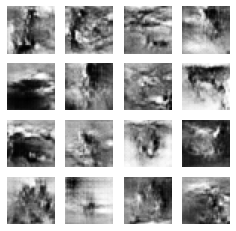

Time for training : 3123 sec


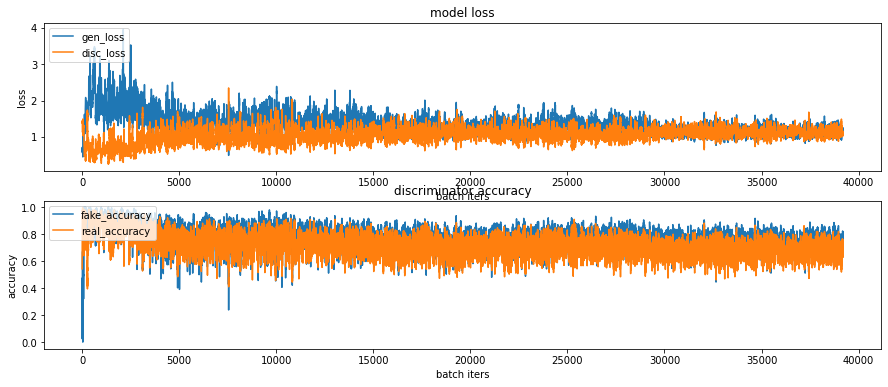

CPU times: user 53min 50s, sys: 4min 15s, total: 58min 6s
Wall time: 52min 6s


In [31]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [32]:
anim_file = os.getenv('HOME')+'/aiffel/10dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/10dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/10dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 4477040 Feb 15 05:53 /aiffel/aiffel/10dcgan_newimage/cifar10/cifar10_dcgan.gif


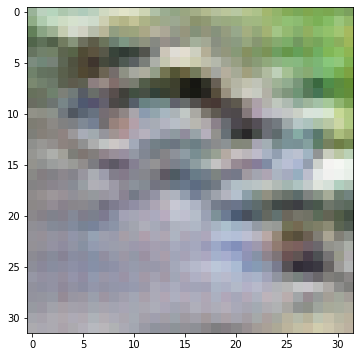

In [38]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/10dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

# 회고
https://www.facebook.com/groups/847991005393886/posts/%EC%95%88%EB%85%95%ED%95%98%EC%84%B8%EC%9A%94-DCGAN-%EA%B4%80%EB%A0%A8-%EC%A7%88%EB%AC%B8%EC%9D%84-%ED%95%98%EB%82%98-%ED%95%98%EA%B3%A0%EC%8B%B6%EC%8A%B5%EB%8B%88%EB%8B%A4/1007229912803327/


이번 프로젝트의 모델을 쭉 살펴보다가 discriminator_model에 마지막 dense층에 왜 활성화함수를 사용하지 않았는지 의문이 들어서 찾아보다가 위의 질문을 보고 sigmoid 함수를 넣어봤다. 

없는 것 보다는 그래프가 좀 더 좋게 나오는 것처럼 보이나, 이게 큰 차이가 있는지는 모르겠다,,,

위의 글에서 답변이 'Discriminator의 output을 0~1사이의 확률값 형태로 mapping하기 위함이라고 보시면 될 것 같습니다'라고 되어있는데,
단순히 mapping만 하기 때문에 큰 차이가 나지 않는 것 같다.

LMS에 참고자료로 나와있는 것을 봤는데 판별자에는 옵티마이저를 SGD를 쓰면 좋다(adam만 써라는 글도 있었다)라던가 dropout을 0.5로 해주면 좋다는 글을 보고 적용시켜보았다.

일단 판별자에 SGD를 써봤을 때는 적어도 내 코드에서는 결과가 꽝이었다,, 

에포크를 200으로 똑같이 돌려도 아주 형체를 아예 알아볼 수 없는 아이만 나왔다 ㅠㅠㅠ

드롭아웃 같은 경우는 샘플에서 아주 약간의 차이가 있는 것처럼 보이기는 했으나 0.3이 더 나아보였다,,


    -옵티마이저를 SGD로 했을 때 그래프( epochs = 200 )


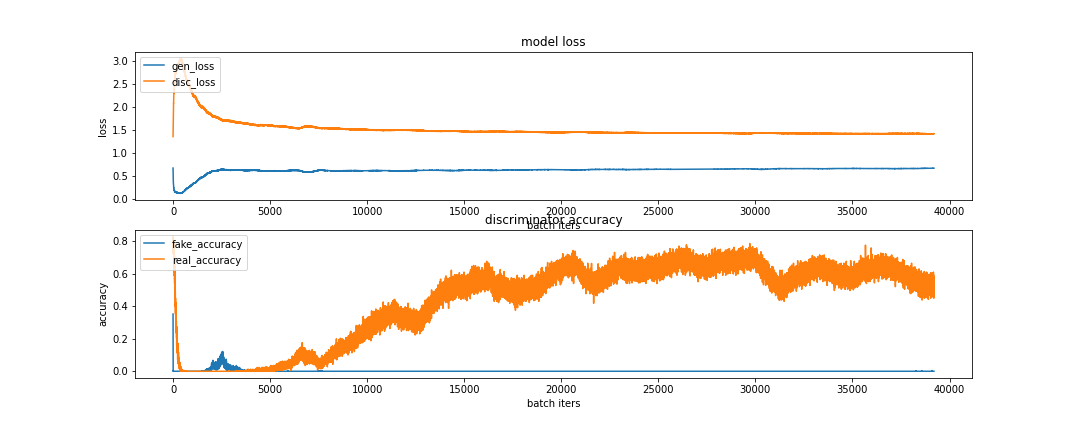


    



    -옵티마이저를 SGD로 했을 때 결과물 ( epochs = 200 )


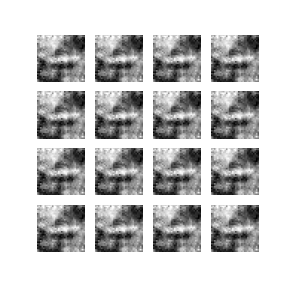


지금코드에서 나오는 것처럼 옵티마이저를 둘 다 adam으로 한 것과 판별자를 SGD로 한 것에는 샘플에서부터 큰 차이가 났다.

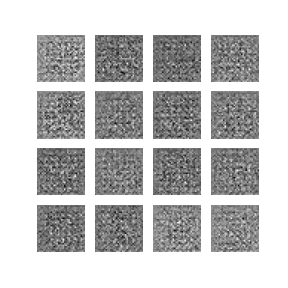

옵티마이저를 adam으로 하고 900epochs를 돌려 봤을 때 샘플인데 지금 나오는 200보다 살짝 덜 흐릴 뿐 큰 차이는 없어보인다.

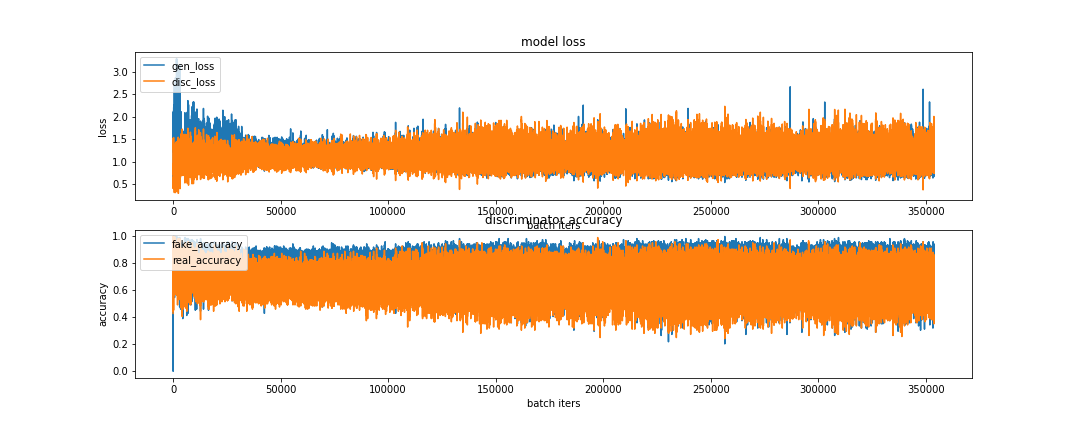

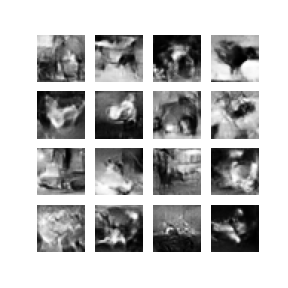

    -epochs 900일 때 그래프와 샘플사진

이번 exploration에서는 코드를 한줄한줄 분석해보려고 했으나, 분석하다보니 여기저기 모르는게 너무 많아서 다 하지 못해서 아쉬웠다,,

분석하겠다고 마음먹은거 exploration 1부터 다 분석해봐야겠다.